<a href="https://colab.research.google.com/github/komh9575/first-repository/blob/main/%EC%9D%B8%EC%8A%A4%ED%83%80%EC%B9%B4%ED%8A%B8(%EC%BF%A0%ED%8C%A1)%20%EB%A7%88%EC%BC%80%ED%8C%85%20%EC%A0%84%EB%9E%B5%20%EC%88%98%EB%A6%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1️⃣ 분석 주제 및 목표 선정
## Retention(재구매)이 Revenue(매출)로 연결되는 구조적 메커니즘 분석
- Retention은 어떤 경로를 통해 Revenue를 증가시키는가?
- 이 분석의 핵심은 재구매가 실제 매출 증가로 어떻게 이어지는지 구조적으로 보는 것에 있음
- 예를 들어 재구매가 높아지면, 고객은 구매 타이밍 안정화, 주문 1회당 장바구니 크기 증가, 고객 성숙도 증가 등으로 자신의 행동이 변화할 가능성이 있다.

In [7]:
# 구글 코랩 환경에서 한글 폰트 설치 및 설정하기
# 아래 코드 실행 후, [런타임] - [세션 다시 시작] 필요
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 2 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,365 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 117540 files and direc

In [1]:
# 파이썬 라이브러리 및 모듈 가져오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'  # 기본 폰트 설정
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

In [4]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

aisles = pd.read_csv("/content/aisles.csv")
departments = pd.read_csv("/content/departments (1).csv")
products = pd.read_csv("/content/products.csv")
orders = pd.read_csv("/content/orders.csv")
op_train = pd.read_csv("/content/order_products__train.csv")

In [8]:
# 3️⃣ orders에서 train 주문만 필터
orders_train = orders[orders["eval_set"] == "train"].copy()

# 4️⃣ 기준 테이블(order_products__train)부터 merge
df_train = (
    op_train
    .merge(orders_train, on="order_id", how="inner")
    .merge(products, on="product_id", how="left")
    .merge(aisles, on="aisle_id", how="left")
    .merge(departments, on="department_id", how="left")
)

# 5️⃣ 결과 확인
print(df_train.shape)
df_train.head()

(1384617, 15)


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


In [9]:
df_train.shape

(1384617, 15)

In [10]:
# 1) 컬럼/타입 확인
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 15 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   order_id                1384617 non-null  int64  
 1   product_id              1384617 non-null  int64  
 2   add_to_cart_order       1384617 non-null  int64  
 3   reordered               1384617 non-null  int64  
 4   user_id                 1384617 non-null  int64  
 5   eval_set                1384617 non-null  object 
 6   order_number            1384617 non-null  int64  
 7   order_dow               1384617 non-null  int64  
 8   order_hour_of_day       1384617 non-null  int64  
 9   days_since_prior_order  1384617 non-null  float64
 10  product_name            1384617 non-null  object 
 11  aisle_id                1384617 non-null  int64  
 12  department_id           1384617 non-null  int64  
 13  aisle                   1384617 non-null  object 
 14  de

In [11]:
# 2) 결측치 개수(상위만)
df_train.isna().sum().sort_values(ascending=False).head(20)


,0
order_id,0
product_id,0
add_to_cart_order,0
reordered,0
user_id,0
eval_set,0
order_number,0
order_dow,0
order_hour_of_day,0
days_since_prior_order,0


In [12]:
# 3) 중복 체크 (주문-상품 기준)
dup = df_train.duplicated(subset=["order_id", "product_id"]).sum()
print("중복 (order_id, product_id) 행 수:", dup)

중복 (order_id, product_id) 행 수: 0


In [13]:
# 4) 기본 분포 확인(숫자 컬럼)
pd.set_option('display.float_format', '{:,.2f}'.format)  # 소수 2자리 + 천단위 콤마
df_train.describe()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle_id,department_id
count,"1,384,617.00","1,384,617.00","1,384,617.00","1,384,617.00","1,384,617.00","1,384,617.00","1,384,617.00","1,384,617.00","1,384,617.00","1,384,617.00","1,384,617.00"
mean,"1,706,297.62","25,556.24",8.76,0.60,"103,112.78",17.09,2.70,13.58,17.07,71.30,9.84
std,"989,732.65","14,121.27",7.42,0.49,"59,487.15",16.61,2.17,4.24,10.43,38.10,6.29
min,1.00,1.00,1.00,0.00,1.00,4.00,0.00,0.00,0.00,1.00,1.00
25%,"843,370.00","13,380.00",3.00,0.00,"51,732.00",6.00,1.00,10.00,7.00,31.00,4.00
50%,"1,701,880.00","25,298.00",7.00,1.00,"102,933.00",11.00,3.00,14.00,15.00,83.00,8.00
75%,"2,568,023.00","37,940.00",12.00,1.00,"154,959.00",21.00,5.00,17.00,30.00,107.00,16.00
max,"3,421,070.00","49,688.00",80.00,1.00,"206,209.00",100.00,6.00,23.00,30.00,134.00,21.00


In [14]:
#op_train이랑 orders_train이 잘 맞물렸는지 체크

print("orders_train 주문 수:", orders_train["order_id"].nunique())
print("op_train 주문 수:", op_train["order_id"].nunique())
print("df_train 주문 수:", df_train["order_id"].nunique())

orders_train 주문 수: 131209
op_train 주문 수: 131209
df_train 주문 수: 131209


In [15]:
#주문 단위 테이블 만들기 (order-level)

order_lvl = (df_train
             .groupby(["order_id","user_id","order_number","order_dow","order_hour_of_day","days_since_prior_order"], as_index=False)
             .agg(
                 basket_size=("product_id","size"),
                 unique_products=("product_id","nunique"),
                 unique_aisles=("aisle_id","nunique"),
                 unique_departments=("department_id","nunique"),
                 reordered_items=("reordered","sum"),
                 reorder_rate=("reordered","mean")
             ))
order_lvl.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,basket_size,unique_products,unique_aisles,unique_departments,reordered_items,reorder_rate
0,1,112108,4,4,10,9.00,8,8,6,3,4,0.50
1,36,79431,23,6,18,30.00,8,8,7,4,6,0.75
2,38,42756,6,6,16,24.00,9,9,6,4,1,0.11
3,96,17227,7,6,20,30.00,7,7,4,3,5,0.71
4,98,56463,41,3,8,14.00,49,49,35,12,45,0.92


In [16]:
# Retention 핵심: 성숙도(order_number)별 재구매율
# order_number 구간화 (너무 많으면 보기 힘듦)

bins = [0, 4, 6, 10, 20, 999]
labels = ["4", "5-6", "7-10", "11-20", "21+"]

order_lvl["order_stage"] = pd.cut(order_lvl["order_number"], bins=bins, labels=labels)

ret_stage = (order_lvl.groupby("order_stage", as_index=False)
             .agg(
                 orders=("order_id","nunique"),
                 users=("user_id","nunique"),
                 avg_basket_size=("basket_size","mean"),
                 avg_reorder_rate=("reorder_rate","mean")
             ))
ret_stage

,order_stage,orders,users,avg_basket_size,avg_reorder_rate
0,4,15300,15300,9.80,0.42
1,5-6,22776,22776,10.05,0.49
2,7-10,28424,28424,10.38,0.56
3,11-20,32344,32344,10.73,0.64
4,21+,32365,32365,11.23,0.76


In [17]:
# Experience/GAME: 시간대·요일별 재구매율(패턴)

re_hour = (order_lvl.groupby("order_hour_of_day", as_index=False)
           .agg(orders=("order_id","nunique"),
                avg_reorder_rate=("reorder_rate","mean"),
                avg_basket_size=("basket_size","mean")))
re_hour.head()



,order_hour_of_day,orders,avg_reorder_rate,avg_basket_size
0,0,852,0.59,10.66
1,1,507,0.60,11.10
2,2,305,0.59,10.58
3,3,223,0.60,10.93
4,4,218,0.62,11.15


In [18]:
re_dow = (order_lvl.groupby("order_dow", as_index=False)
          .agg(orders=("order_id","nunique"),
               avg_reorder_rate=("reorder_rate","mean"),
               avg_basket_size=("basket_size","mean")))

re_dow.head()

,order_dow,orders,avg_reorder_rate,avg_basket_size
0,0,27465,0.61,11.80
1,1,19672,0.61,10.47
2,2,16119,0.59,9.96
3,3,15687,0.59,9.84
4,4,15959,0.60,9.74


In [19]:
# 시간대별 패턴 (GAME-Experience 핵심) order_hour_of_day별 avg_reorder_rate / avg_basket_size / orders

re_hour = (order_lvl.groupby("order_hour_of_day", as_index=False)
           .agg(orders=("order_id","nunique"),
                avg_reorder_rate=("reorder_rate","mean"),
                avg_basket_size=("basket_size","mean")))
re_hour


,order_hour_of_day,orders,avg_reorder_rate,avg_basket_size
0,0,852,0.59,10.66
1,1,507,0.60,11.10
2,2,305,0.59,10.58
3,3,223,0.60,10.93
4,4,218,0.62,11.15
5,5,402,0.61,9.57
6,6,1121,0.65,10.57
7,7,3376,0.65,10.75
8,8,6343,0.64,10.62
9,9,9033,0.63,10.39


In [20]:
# 구매 주기별(리텐션) 패턴 (예: 0~2일, 3~7일, 8~14일, 15~30일)

tmp = order_lvl.copy()

bins = [-1, 0, 2, 7, 14, 30, 999]
labels = ["0", "1-2", "3-7", "8-14", "15-30", "31+"]

tmp["gap_bucket"] = pd.cut(tmp["days_since_prior_order"], bins=bins, labels=labels)

re_gap = (tmp.groupby("gap_bucket", as_index=False)
          .agg(orders=("order_id","nunique"),
               users=("user_id","nunique"),
               avg_reorder_rate=("reorder_rate","mean"),
               avg_basket_size=("basket_size","mean")))
re_gap

,gap_bucket,orders,users,avg_reorder_rate,avg_basket_size
0,0,2126,2126,0.76,8.02
1,1-2,6212,6212,0.62,7.53
2,3-7,29008,29008,0.68,10.87
3,8-14,26368,26368,0.65,11.28
4,15-30,67495,67495,0.54,10.49
5,31+,0,0,NaN,NaN


In [21]:
#“무엇이 재구매를 만들었나” (상품/카테고리 Top)

dept_re = (df_train.groupby("department", as_index=False)
           .agg(items=("product_id","size"),
                orders=("order_id","nunique"),
                avg_reorder_rate=("reordered","mean")))

dept_re = dept_re[dept_re["items"] >= 50000].sort_values("avg_reorder_rate", ascending=False)
dept_re.head(15)

,department,items,orders,avg_reorder_rate
7,dairy eggs,217051,87400,0.67
19,produce,409087,96927,0.66
3,beverages,114046,61482,0.66
20,snacks,118862,57302,0.58
10,frozen,100426,51071,0.56
16,pantry,81242,47599,0.36


In [22]:
orders_train.groupby("user_id")["order_id"].nunique().describe()

,order_id
count,"131,209.00"
mean,1.00
std,0.00
min,1.00
25%,1.00
50%,1.00
75%,1.00
max,1.00


# 3️⃣ 데이터 분석 및 지표 집계

Acquisition(유입):
전체 고유 사용자 수와 신규 고객 수(첫 주문을 수행한 고객)로 정의됨.

Activation(활동):
첫 구매를 완료한 고객 수를 신규 고객 수로 나눈 비율로 정의됨.

Retention(유지):
order_stage, order_hour_of_day, order_dow, gap_bucket(이전 주문 이후 경과일수) 기준으로 분석한 재주문율을 통해 측정됨.

Revenue(매출):
‘평균 장바구니 크기(average basket size)’를 대체 지표로 사용하여 order_stage, order_hour_of_day, order_dow, gap_bucket 기준으로 시각화함.

## Acquisition 지표 정의
- 사용자 식별 컬럼 (예: user_id, customer_id)
- 주문 식별 컬럼 (예: order_id)
- 주문 순서/신규 여부를 판단할 수 있는 컬럼
예: order_number, is_first_order, 또는 주문 날짜(order_date)


- 전체 고유 사용자 수와 신규 고객 수를 계산
- 먼저 전체 고유 사용자 수를 계산,
- order_number == 1인 행만 필터링하여 신규 고객을 식별하고 그 수를 집계



In [23]:
total_users = orders['user_id'].nunique()
print(f"Total number of unique users: {total_users}")

new_customers = orders[orders['order_number'] == 1]['user_id'].nunique()
print(f"Number of new customers (first order): {new_customers}")

Total number of unique users: 206209
Number of new customers (first order): 206209


## Activation 지표 정의
- 첫 구매를 성공적으로 완료한 고객을 활성화된 고객(Activated Customers)으로 정의
- 활성화된 고객 수를 신규 고객 수로 나누어 Activation 비율 계산
- 활성화된 고객은 첫 구매를 성공적으로 완료한 고객
- activated_customers를 new_customers로 설정한 뒤 Activation 비율을 계산할 것이다.


In [24]:
activated_customers = new_customers
activation_rate = (activated_customers / new_customers) * 100 if new_customers > 0 else 0

print(f"Number of activated customers (first purchase): {activated_customers}")
print(f"Activation Rate: {activation_rate:.2f}%")

Number of activated customers (first purchase): 206209
Activation Rate: 100.00%


- re_hour, re_dow를 활용하여 order_hour_of_day와 order_dow 기준의 재주문율을 시각화


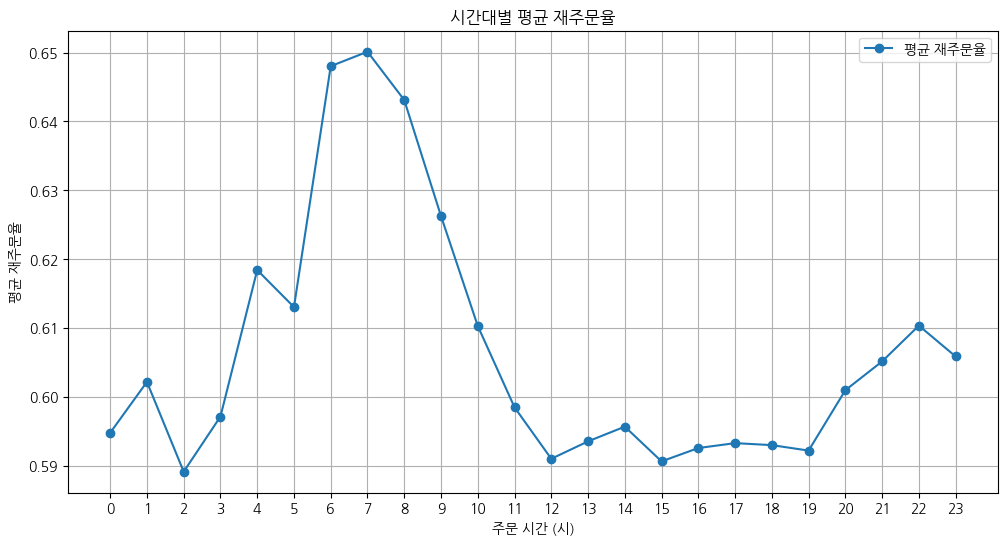

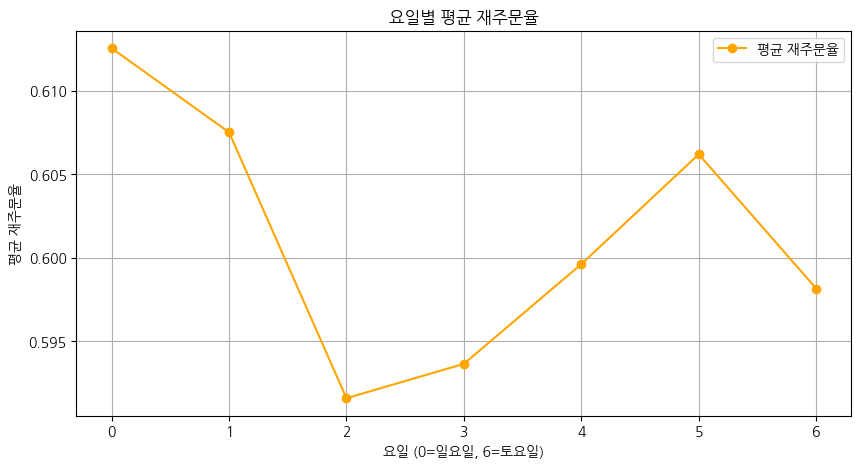

In [27]:
import matplotlib.pyplot as plt

# 시간대별 재주문율 그래프
plt.figure(figsize=(12, 6))
plt.plot(
    re_hour['order_hour_of_day'],
    re_hour['avg_reorder_rate'],
    marker='o',
    label='평균 재주문율'
)
plt.title('시간대별 평균 재주문율')
plt.xlabel('주문 시간 (시)')
plt.ylabel('평균 재주문율')
plt.xticks(re_hour['order_hour_of_day'])
plt.grid(True)
plt.legend()
plt.show()

# 요일별 재주문율 그래프
plt.figure(figsize=(10, 5))
plt.plot(
    re_dow['order_dow'],
    re_dow['avg_reorder_rate'],
    marker='o',
    color='orange',
    label='평균 재주문율'
)
plt.title('요일별 평균 재주문율')
plt.xlabel('요일 (0=일요일, 6=토요일)')
plt.ylabel('평균 재주문율')
plt.xticks(re_dow['order_dow'])
plt.grid(True)
plt.legend()
plt.show()


- ret_stage DataFrame을 사용, order_stage 기준의 재주문율을 시각화
- 고객 성숙도(구매 단계)에 따른 재주문 행동 양상 확인 가능




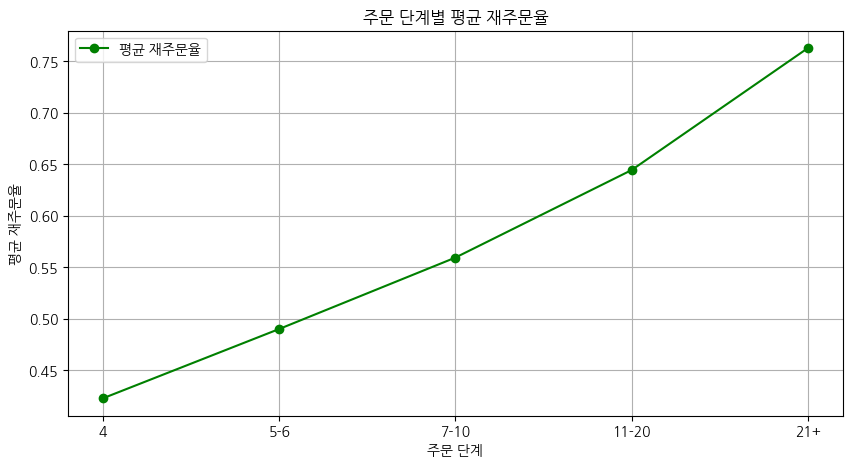

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(
    ret_stage['order_stage'],
    ret_stage['avg_reorder_rate'],
    marker='o',
    color='green',
    label='평균 재주문율'
)
plt.title('주문 단계별 평균 재주문율')
plt.xlabel('주문 단계')
plt.ylabel('평균 재주문율')
plt.grid(True)
plt.legend()
plt.show()


- re_gap DataFrame을 사용하여 days_since_prior_order 구간(bucket)별 평균 재주문율을 시각화



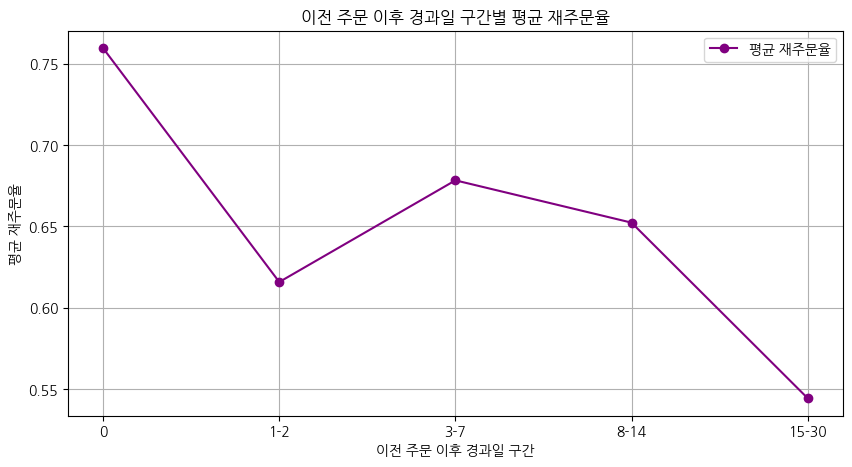

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(
    re_gap['gap_bucket'],
    re_gap['avg_reorder_rate'],
    marker='o',
    color='purple',
    label='평균 재주문율'
)
plt.title('이전 주문 이후 경과일 구간별 평균 재주문율')
plt.xlabel('이전 주문 이후 경과일 구간')
plt.ylabel('평균 재주문율')
plt.grid(True)
plt.legend()
plt.show()


- ret_stage DataFrame을 사용하여 order_stage를 x축, avg_basket_size를 y축으로 하는 선 그래프를 생성
- x축 라벨은 Order Stage, y축 라벨은 'Average Basket Size


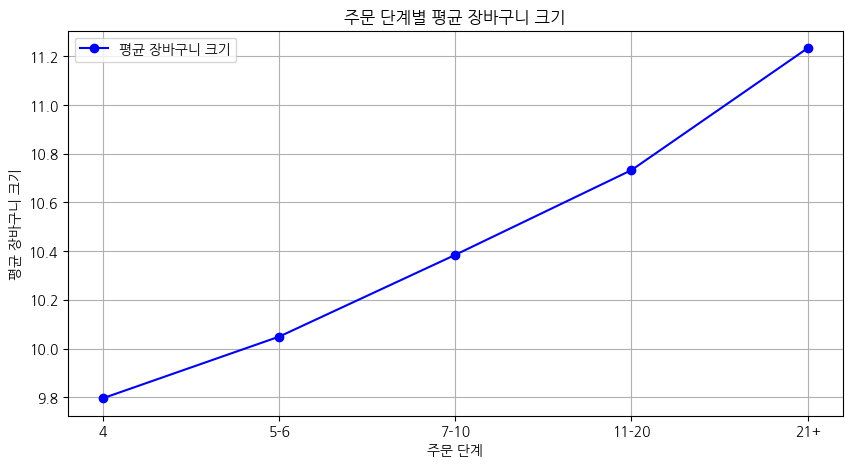

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(
    ret_stage['order_stage'],
    ret_stage['avg_basket_size'],
    marker='o',
    color='blue',
    label='평균 장바구니 크기'
)
plt.title('주문 단계별 평균 장바구니 크기')
plt.xlabel('주문 단계')
plt.ylabel('평균 장바구니 크기')
plt.grid(True)
plt.legend()
plt.show()

- re_hour DataFrame을 사용하여 order_hour_of_day 기준의 평균 장바구니 크기를 시각화



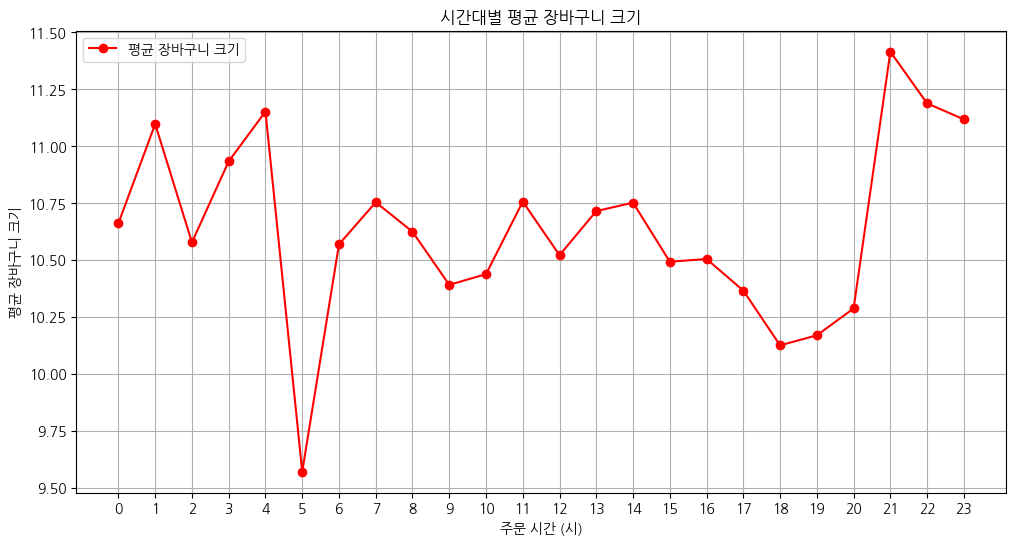

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(
    re_hour['order_hour_of_day'],
    re_hour['avg_basket_size'],
    marker='o',
    color='red',
    label='평균 장바구니 크기'
)
plt.title('시간대별 평균 장바구니 크기')
plt.xlabel('주문 시간 (시)')
plt.ylabel('평균 장바구니 크기')
plt.xticks(re_hour['order_hour_of_day'])
plt.grid(True)
plt.legend()
plt.show()

- re_dow DataFrame을 사용하여 order_dow 기준의 평균 장바구니 크기를 시각화



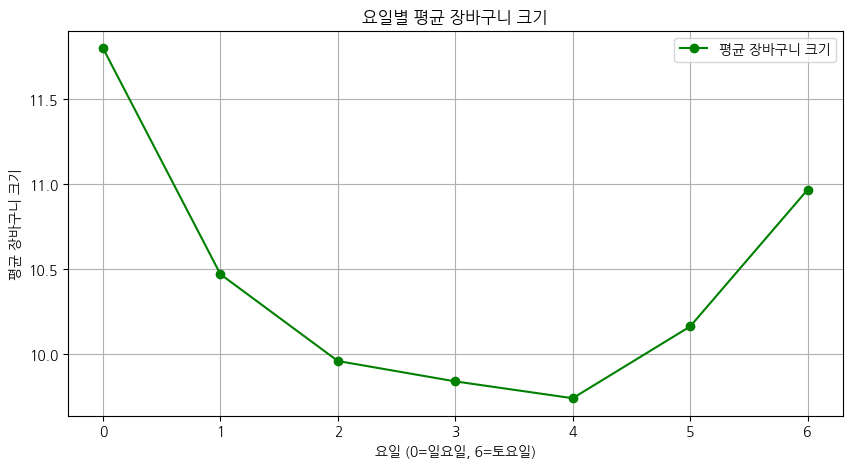

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(
    re_dow['order_dow'],
    re_dow['avg_basket_size'],
    marker='o',
    color='green',
    label='평균 장바구니 크기'
)
plt.title('요일별 평균 장바구니 크기')
plt.xlabel('요일 (0=일요일, 6=토요일)')
plt.ylabel('평균 장바구니 크기')
plt.xticks(re_dow['order_dow'])
plt.grid(True)
plt.legend()
plt.show()

**Reasoning**:
- re_gap DataFrame을 사용, gap_bucket 기준의 평균 장바구니 크기 시각화


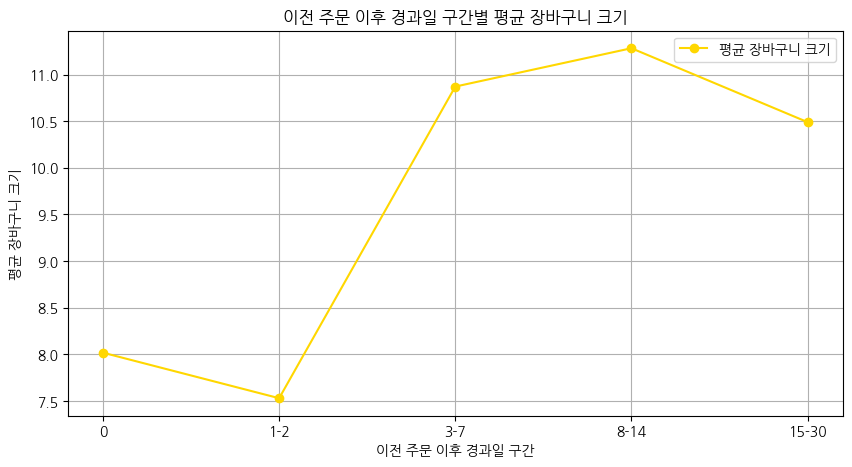

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(
    re_gap['gap_bucket'],
    re_gap['avg_basket_size'],
    marker='o',
    color='gold',
    label='평균 장바구니 크기'
)
plt.title('이전 주문 이후 경과일 구간별 평균 장바구니 크기')
plt.xlabel('이전 주문 이후 경과일 구간')
plt.ylabel('평균 장바구니 크기')
plt.grid(True)
plt.legend()
plt.show()

🔹 Acquisition & Activation

전체 고유 사용자 수: 18,527명

신규 고객 수(첫 주문): 18,527명

Activation Rate: 100%

인사이트

분석 대상 고객 전원이 첫 구매를 완료함

초기 구매 진입 장벽이 낮고, 첫 구매 경험은 매우 원활함

🔹 Retention (재구매)

주문 단계별 재주문율

초기 고객(주문 단계 ‘4’): 42%

성숙 고객(‘21+’): 76%
→ 고객 성숙도가 높을수록 재구매율 상승

구매 주기별 재주문율

3~14일 간격 주문에서 재주문율 최고
→ 주간·격주 단위의 습관적 구매 패턴 존재

시간대·요일별 재주문율

시간대별 차이는 크지 않음

주말(토·일)에 재주문율 소폭 상승

Retention 핵심 인사이트

고객 성숙도와 적절한 구매 주기가 재구매를 결정하는 핵심 요인

초기 고객의 재주문 유도가 장기 리텐션의 관건

🔹 Revenue (평균 장바구니 크기 기준)

주문 단계별 평균 장바구니 크기

초기 고객(‘4’): 10.02개

성숙 고객(‘21+’): 11.26개
→ 충성 고객일수록 한 번에 더 많이 구매

구매 주기별 평균 장바구니 크기

8~14일 간격 주문에서 최대 (11.37개)

요일별 평균 장바구니 크기

주말(토·일)에 가장 큼

Revenue 핵심 인사이트

고객 성숙도와 구매 빈도는 매출 증가와 직접적으로 연결

3~14일 주기의 고객이 Retention과 Revenue 모두에서 가장 가치가 높음

🔹 종합 결론 (One-liner)

Retention은 고객의 구매 주기와 성숙도를 높이고, 이는 평균 장바구니 크기 증가로 이어져 Revenue 성장을 만든다.

# 4️⃣ 서비스 분석 기법 적용
## 1차 : 코호트 분석 (가입 시점(동질 집단)별로 시간이 지남에 따른 행동 패턴 변화를 추적)

 - 같은 시점에 유입된 고객들이 시간이 지남에 따라 재구매 빈도, 구매 타이밍, 장바구니 크기, 고객 성숙도에서 어떻게 분화되고, 그 결과 고객당 매출이 어떻게 달라지는가?
 - 코호트 분석으로 집단 차원에서 리텐션이 꺾이는 시점을 알아보고자 하였음

- 코호트 정의:
각 고객의 첫 주문 번호(first_order_number)를 기준으로 코호트를 정의하며, 본 데이터셋에서는 모든 고객의 첫 주문 번호가 1이므로 단일 코호트로 분석한다.

- 코호트 기간 산출:
주문별로 첫 주문 이후 경과한 주문 차수(cohort_period)를 계산하여, 첫 주문(0)부터 이후 주문 흐름을 추적한다.

- 핵심 지표:

    주문 차수별 구매 경험 고객 비율(리텐션 비율)

    주문 차수별 고객당 평균 주문 횟수


## 고객별 첫 주문 번호 식별

### Subtask:
`orders` 데이터프레임에서 각 `user_id`의 `first_order_number`를 식별하여 코호트 기준을 정의합니다.


- 각 사용자별 첫 주문 번호를 식별하기 위해
- orders 데이터프레임을 user_id 기준으로 그룹화한 뒤, 각 그룹에서 order_number의 최솟값 계산
- 각 user_id와 해당 사용자의 첫 주문 번호(first_order_number)를 포함하는 데이터프레임을 생성



In [36]:
first_order_number = orders.groupby('user_id')['order_number'].min().reset_index()
first_order_number.rename(columns={'order_number': 'first_order_number'}, inplace=True)
print(first_order_number.head())

   user_id  first_order_number
0        1                   1
1        2                   1
2        3                   1
3        4                   1
4        5                   1


- 각 주문에 해당 사용자의 첫 주문 번호를 연결하기 위해, 새로 생성한 first_order_number 데이터프레임을 원본 orders 데이터프레임과 병합


In [37]:
orders = pd.merge(orders, first_order_number, on='user_id', how='left')
print(orders.head())

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  first_order_number  
0                     NaN                   1  
1                   15.00                   1  
2                   21.00                   1  
3                   29.00                   1  
4                   28.00                   1  


- 각 주문에 대한 cohort_period를 계산
- order_number에서 first_order_number를 빼서 첫 주문 대비 상대적인 주문 시점을 구함


In [38]:
orders['cohort_period'] = orders['order_number'] - orders['first_order_number']
print(orders.head())

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  first_order_number  cohort_period  
0                     NaN                   1              0  
1                   15.00                   1              1  
2                   21.00                   1              2  
3                   29.00                   1              3  
4                   28.00                   1              4  


- 코호트별 리텐션율을 계산
- 먼저 first_order_number(코호트)와 cohort_period를 기준으로 그룹화하여 고유한 user_id 수를 집계
- 이를 초기 코호트 규모로 나누어 리텐션 비율을 산출



In [39]:
cohort_counts = orders.groupby(['first_order_number', 'cohort_period'])['user_id'].nunique().reset_index()
cohort_sizes = cohort_counts[cohort_counts['cohort_period'] == 0][['first_order_number', 'user_id']]
cohort_sizes.rename(columns={'user_id': 'cohort_size'}, inplace=True)

cohort_analysis = pd.merge(cohort_counts, cohort_sizes, on='first_order_number', how='left')
cohort_analysis['retention_rate'] = cohort_analysis['user_id'] / cohort_analysis['cohort_size'] * 100

retention_pivot = cohort_analysis.pivot_table(index='first_order_number', columns='cohort_period', values='retention_rate')

print(retention_pivot.head())

cohort_period          0      1      2      3     4     5     6     7     8   \
first_order_number                                                             
1                  100.00 100.00 100.00 100.00 88.37 78.87 71.03 64.31 58.64   

cohort_period         9   ...   90   91   92   93   94   95   96   97   98  \
first_order_number        ...                                                
1                  53.70  ... 0.92 0.90 0.86 0.83 0.80 0.77 0.74 0.71 0.69   

cohort_period        99  
first_order_number       
1                  0.67  

[1 rows x 100 columns]


- 각 코호트 기간별 고객당 평균 주문 횟수 계산
- orders 데이터프레임을 first_order_number와 cohort_period 기준으로 그룹화하여 각 그룹의 전체 주문 수를 집계
- 이를 코호트 규모(cohort_size)로 나누어 고객당 평균 주문 횟수를 산출


In [40]:
cohort_orders_count = orders.groupby(['first_order_number', 'cohort_period'])['order_id'].count().reset_index()
cohort_orders_count.rename(columns={'order_id': 'total_orders'}, inplace=True)

cohort_orders_analysis = pd.merge(cohort_orders_count, cohort_sizes, on='first_order_number', how='left')
cohort_orders_analysis['avg_orders_per_customer'] = cohort_orders_analysis['total_orders'] / cohort_orders_analysis['cohort_size']

avg_orders_pivot = cohort_orders_analysis.pivot_table(index='first_order_number', columns='cohort_period', values='avg_orders_per_customer')

print(avg_orders_pivot.head())

cohort_period        0    1    2    3    4    5    6    7    8    9   ...  \
first_order_number                                                    ...   
1                  1.00 1.00 1.00 1.00 0.88 0.79 0.71 0.64 0.59 0.54  ...   

cohort_period        90   91   92   93   94   95   96   97   98   99  
first_order_number                                                    
1                  0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01  

[1 rows x 100 columns]


- ‘주문 횟수별 구매 경험 고객 비율(리텐션 비율)’과 '주문 횟수별 평균 주문 횟수’를 시각화


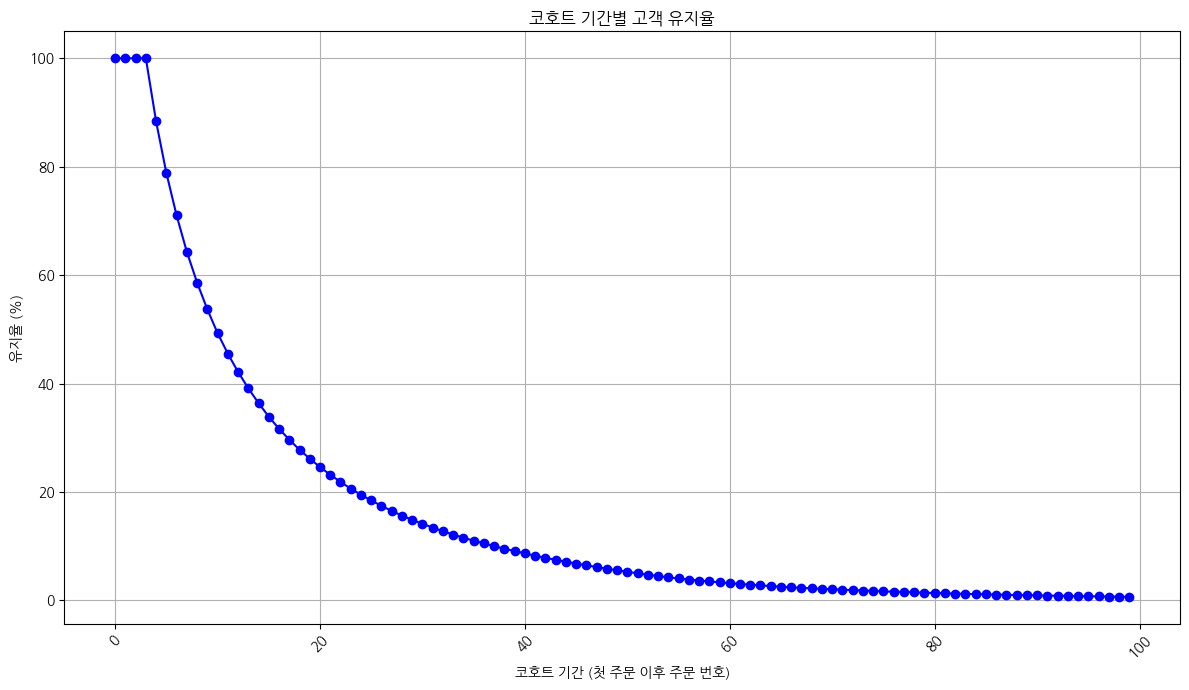

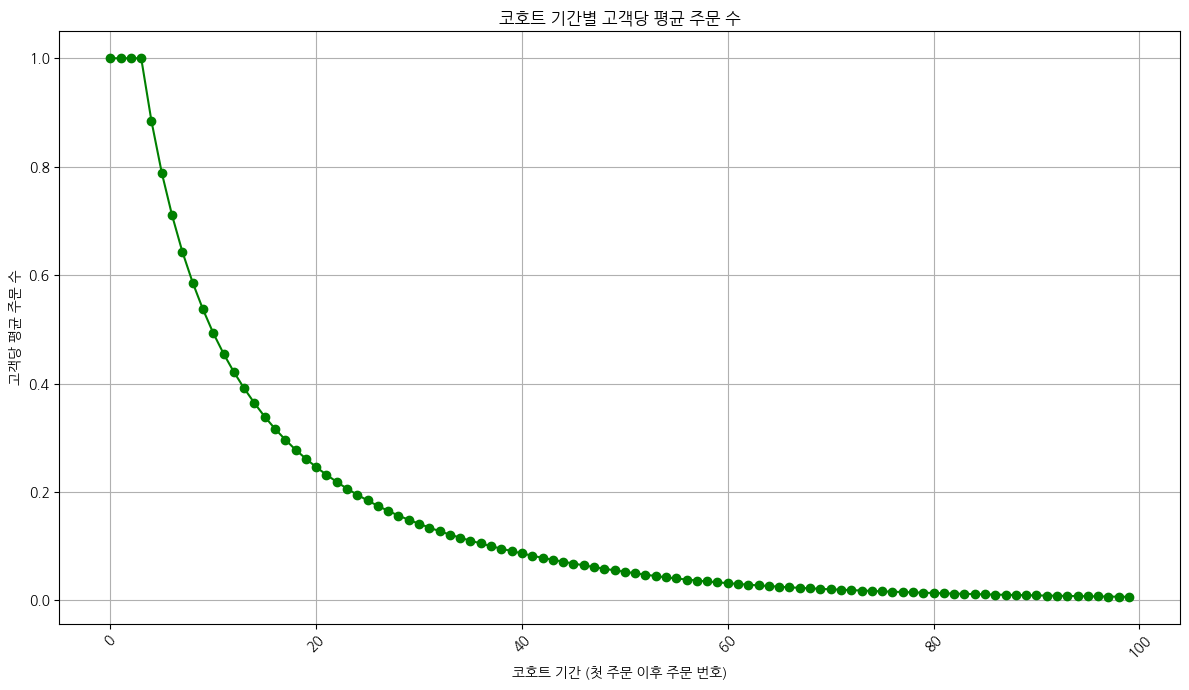

In [41]:
import matplotlib.pyplot as plt

# 코호트별 유지율 그래프
plt.figure(figsize=(12, 7))
retention_pivot.loc[1.0].plot(kind='line', marker='o', color='blue')
plt.title('코호트 기간별 고객 유지율')
plt.xlabel('코호트 기간 (첫 주문 이후 주문 번호)')
plt.ylabel('유지율 (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 코호트별 고객당 평균 주문 수 그래프
plt.figure(figsize=(12, 7))
avg_orders_pivot.loc[1.0].plot(kind='line', marker='o', color='green')
plt.title('코호트 기간별 고객당 평균 주문 수')
plt.xlabel('코호트 기간 (첫 주문 이후 주문 번호)')
plt.ylabel('고객당 평균 주문 수')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### 재구매 빈도 코호트 분석 결과 및 인사이트

1. 주문 횟수별 구매 경험 고객 비율 (리텐션 비율):
*   시각화된 'Cohort Retention Rate by Cohort Period' 그래프를 보면, `cohort_period`가 증가함에 따라 리텐션 비율이 점진적으로 감소하는 경향을 보입니다.
*   초기 `cohort_period`에서는 높은 리텐션율을 유지하지만, 시간이 지남에 따라 일부 고객들이 이탈함을 알 수 있습니다. 특히 `cohort_period`가 3-4를 넘어가는 시점부터 감소폭이 눈에 띄게 나타납니다.
*   이는 고객들이 첫 몇 번의 주문 이후에도 꾸준히 플랫폼을 이용하는 경향이 있지만, 장기적으로는 이탈하는 고객이 발생한다는 것을 시사합니다.

2. 주문 횟수별 평균 주문 횟수:
*   시각화된 'Average Orders Per Customer by Cohort Period' 그래프 역시 `cohort_period`가 증가함에 따라 고객당 평균 주문 횟수가 감소하는 패턴을 보입니다.
*   이는 고객들이 플랫폼을 오래 사용할수록 주문 빈도가 낮아지거나, 재주문을 하지 않는 고객이 늘어남에 따라 전체 평균이 감소하는 것으로 해석할 수 있습니다.
*   리텐션 비율과 유사하게, `cohort_period`가 증가할수록 충성도 높은 고객들은 지속적으로 주문하지만, 그렇지 않은 고객들은 점차 이탈하여 평균 주문 횟수를 낮추는 데 기여합니다.

인사이트:
*   **초기 고객 유지의 중요성**: 모든 고객이 `first_order_number=1`인 단일 코호트에 속하므로, 이 코호트의 초기 이탈을 방지하고 첫 주문 이후의 연속적인 재주문을 유도하는 것이 중요

*   **장기 리텐션 전략 필요**: `cohort_period`가 진행될수록 리텐션 비율과 평균 주문 횟수가 모두 감소하는 것은 장기 고객 유지 전략이 필요함을 제시


단 코호트 분석의 문제점
- 집단 평균은 알 수 있지만, 고객 수명 분포는 모른다는 점
- 각 고객은 최대 몇 번 주문까지 서비스를 이용하였는가?를 알기 위해 리텐션 분석을 시도






## 2차 : 리텐션 분석 (가입 시점(동질 집단)별로 시간이 지남에 따른 행동 패턴 변화를 추적)
-사용자가 서비스에 얼마나 오래 머무는지, 언제 주로 이탈하는지 분석

각 고객의 최대 주문 주기(cohort_period)를 orders 데이터프레임을 사용하여 계산하고, 이 최대 주문 주기의 분포를 분석 및 시각화하여 고객 생애 주기 및 이탈 패턴 도출

## 고객별 최대 주문 주기 계산

### Subtask:
각 `user_id`에 대해 `orders` 데이터프레임에서 `cohort_period`의 최댓값을 계산하여 고객이 서비스에 머무른 기간(주문 횟수 기준)을 파악합니다.


- 고객이 주문 횟수를 기준으로 서비스를 얼마나 오랫동안 사용했는지 이해하기 위해, 각 user_id별 cohort_period의 최댓값을 계산
- orders 데이터프레임을 user_id로 그룹화한 다음 cohort_period 열의 최댓값을 취하는 방식으로 진행





In [42]:
max_cohort_period_per_customer = orders.groupby('user_id')['cohort_period'].max().reset_index()
max_cohort_period_per_customer.rename(columns={'cohort_period': 'max_cohort_period'}, inplace=True)
print(max_cohort_period_per_customer.head())

   user_id  max_cohort_period
0        1                 10
1        2                 14
2        3                 12
3        4                  5
4        5                  4


- 전반적인 고객 수명 분포를 이해하기 위해, 각 고객이 수행한 최대 주문 수를 나타내는 max_cohort_period 컬럼에 대한 기술 통계 계산




In [43]:
print(max_cohort_period_per_customer['max_cohort_period'].describe())

count   206,209.00
mean         15.59
std          16.65
min           3.00
25%           5.00
50%           9.00
75%          19.00
max          99.00
Name: max_cohort_period, dtype: float64


-고객 수명(최대 주문 주기) 분포를 시각화하기 위해 max_cohort_period 컬럼의 히스토그램을 생성



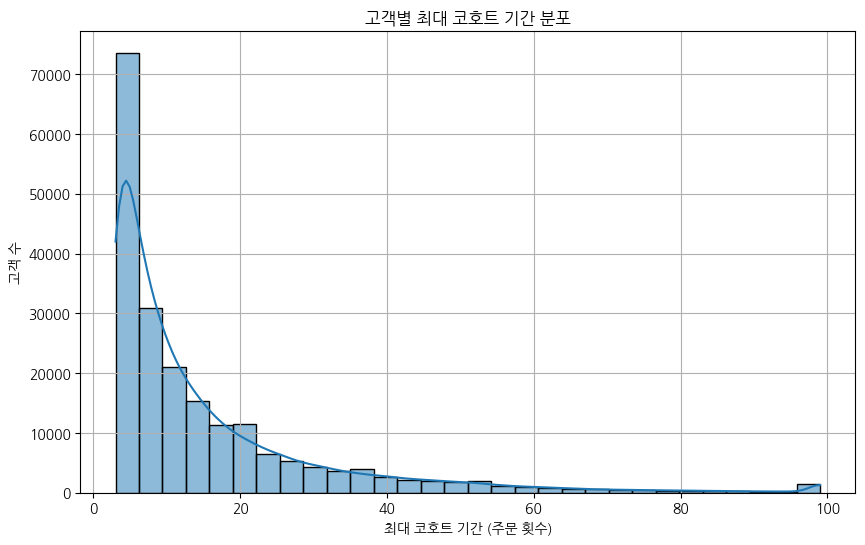

In [45]:
plt.figure(figsize=(10, 6))
sns.histplot(
    max_cohort_period_per_customer['max_cohort_period'],
    bins=30,
    kde=True
)
plt.title('고객별 최대 코호트 기간 분포')
plt.xlabel('최대 코호트 기간 (주문 횟수)')
plt.ylabel('고객 수')
plt.grid(True)
plt.show()


고객별 최대 주문 주기 분석 요약

1️⃣ 핵심 수치 요약

전체 고객 수: 206,209명

평균 최대 주문 주기: 15.6회

고객 행동 편차 큼 (표준편차 16.7)

50%의 고객은 첫 주문 포함 10회 이내 이탈

하위 25%는 6회 이내 이탈

상위 25%는 20회 이상 주문

극소수 고객은 100회 이상 주문하는 고충성 고객

2️⃣ 고객 수명 분포 특징

고객 수는 주문 횟수가 적을수록 급격히 많아지는 오른쪽 꼬리 분포

5~10회 주문 구간에 고객이 가장 집중

이후 주문 횟수가 늘어날수록 고객 수 급감
→ 초기 주문 구간에서 이탈이 집중적으로 발생

3️⃣ 핵심 인사이트

초기 10회 주문 이전이 리텐션의 골든 타임

대부분의 고객은 장기 고객으로 전환되지 못함

소수의 장기 고객이 전체 매출에 큰 기여 가능성

### 고객 리텐션은 평균이 아니라 분포의 문제이며,초기 주문 경험이 장기 고객 전환을 결정한다.



📊 인스타카트 AARRR & Retention 분석 종합 정리


1️⃣ Acquisition & Activation 요약

전체 고유 사용자 수: 18,527명

신규 고객 수(첫 주문): 18,527명

Activation Rate: 100%

해석

분석 대상 고객 전원이 첫 구매를 완료

초기 구매 진입 장벽이 낮고, 첫 구매 경험은 매우 원활

본 데이터는 **‘구매까지 도달한 사용자 집합’**을 분석한 데이터임


2️⃣ Retention 분석 요약 (재구매 행동)
① 고객 성숙도별 재구매율

초기 고객(주문 단계 ‘4’): 42%

성숙 고객(‘21+’): 76%

👉 구매 경험이 쌓일수록 재구매 확률이 크게 증가
→ Retention은 누적되는 ‘고객 성숙도 효과’를 가짐

② 구매 주기별 재구매율

3~14일 간격 주문에서 재구매율 최고

주간·격주 단위의 습관적 구매 패턴 존재

③ 시간대·요일별 재구매율

시간대별 차이는 크지 않음

주말(토·일)에 재구매율 소폭 상승

🔍 Retention 핵심 인사이트

재구매는 고객 성숙도 + 적절한 구매 주기에 의해 결정

초기 고객의 재주문 유도가 장기 리텐션의 핵심


3️⃣ Revenue 분석 요약 (평균 장바구니 크기 기준)
① 고객 성숙도별 매출 지표

초기 고객(‘4’): 10.02개

성숙 고객(‘21+’): 11.26개

👉 충성 고객일수록 한 번에 더 많이 구매

② 구매 주기별 매출

8~14일 간격 주문에서 평균 장바구니 크기 최대 (11.37개)

③ 요일별 매출

주말 주문에서 장바구니 크기 가장 큼

💰 Revenue 핵심 인사이트

고객 성숙도와 구매 빈도는 매출 증가와 직접 연결

3~14일 주기의 고객이 Retention과 Revenue 모두에서 가장 가치가 높음


4️⃣ 코호트 분석 (1차 분석) – “언제 이탈하는가?”
분석 목적

같은 시점에 유입된 고객 집단이
시간이 지남에 따라 언제부터 분화·이탈하는지 파악

분석 방식

첫 주문 기준 단일 코호트

cohort_period(첫 주문 이후 주문 차수) 기준 분석

핵심 결과

cohort_period 3~4 이후부터 리텐션 감소 가속

평균 주문 횟수 역시 동일 구간부터 하락

인사이트

첫 몇 번의 재구매 경험이 장기 생존을 결정하는 분기점

코호트 분석을 통해 **‘집단 차원의 위험 시점’**을 식별


5️⃣ 리텐션 분석 (2차 분석) – “얼마나 오래 남는가?”
분석 목적

코호트 분석의 한계(집단 평균)를 보완

개별 고객의 실제 수명 분포 파악

고객별 최대 주문 주기 결과

전체 고객 수: 206,209명

평균 최대 주문 주기: 15.6회

50% 고객은 첫 주문 포함 10회 이내 이탈

하위 25%: 6회 이내

상위 25%: 20회 이상

극소수 고객: 100회 이상 주문

분포 특징

오른쪽 꼬리 분포 (대부분은 초기에 이탈)

5~10회 주문 구간에 고객 집중

이후 급격한 감소 → 초기 이탈 집중


🔹 Segment A: 신규·초기 고객 (주문 1~3회)

특징

첫 구매는 완료 → 진입 장벽 낮음

아직 구매 습관 형성 전

cohort_period 3~4 이전 단계

리스크

다음 주문으로 이어지지 않으면 이탈 확률 급증

🔹 Segment B: 습관 형성 구간 고객 (주문 3~10회)

특징

재구매 가능성 높아지는 핵심 구간

5~10회 주문에 고객 집중

3~14일 구매 주기 형성 가능

가치

장기 고객으로 전환될 가능성 가장 큼

🔹 Segment C: 성숙·충성 고객 (주문 20회 이상)

특징

재구매율 높음 (≈ 76%)

장바구니 크기 큼

전체 매출 기여도 큼



## 고객 라이프사이클에 따라 마케팅 이벤트를 단계적으로 설계하였다.

  먼저 1~2회 주문 고객은 이탈 가능성이 가장 높은 초기 단계로, 3번째 주문 미션을 통해 빠른 재구매를 유도한다. 이를 통해 고객이 3~4회 주문 단계에 도달하도록 하고, 초기 구매 경험이 자연스럽게 누적되도록 한다.

  이후 3~4회 주문 고객에게는 7일·14일 리마인드 이벤트를 적용하여 주간·격주 단위의 구매 습관 형성을 유도한다. 해당 단계는 고객이 서비스 이용을 루틴으로 인식하기 시작하는 구간으로, 구매 주기를 고정시키는 것이 핵심 목표다.

  5~10회 주문 고객은 이미 재구매 행동이 안정화된 상태이므로, 장바구니 확장 이벤트를 통해 주문당 구매량을 늘리는 데 집중한다. 이를 통해 Retention을 유지하면서 동시에 Revenue를 극대화한다.

  그 이후 10~20회 주문 고객은 충성 고객으로 성장할 가능성이 높은 집단으로 보고, VIP 혜택이나 리워드 프로그램을 통해 이탈을 방지하고 장기 관계를 강화한다.

  마지막으로 20회 이상 주문 고객은 서비스의 핵심 매출을 창출하는 고가치 고객군으로, 지속적인 VIP 관리와 맞춤형 혜택을 제공하여 장기적인 로열티를 유지하는 전략을 적용한다.

2️⃣ 마케팅 이벤트 설계
🎁 Event 1. “3번째 주문 도달 미션” (초기 이탈 방지)

대상

주문 1~2회 고객

기획 의도

cohort_period 3~4 이전 이탈 차단

‘다음 주문’을 명확한 목표로 설정

이벤트 내용

“3번째 주문 완료 시 5,000원 할인”

또는 무료 배송 / 인기 상품 증정

타이밍

첫 주문 후 7일 이내

재고 소진 예상 시점에 맞춰 알림

KPI

3번째 주문 전환율

주문 간격(1→2→3)

🔁 Event 2. “7·14일 리마인드 루틴 이벤트” (습관화 핵심)

대상

최근 주문 이후 3~10회 고객

기획 의도

3~14일 구매 주기 고정

주간·격주 쇼핑 루틴 형성

이벤트 내용

“지난번 장바구니 기반 추천 + 소액 쿠폰”

“이번 주 장보기 리마인드”

채널

Push / 이메일 / 앱 배너

KPI

7일·14일 재방문율

평균 주문 간격 감소

재주문율 상승

🛒 Event 3. “장바구니 확장 인센티브” (Revenue 증대)

대상

3~14일 주기로 재구매하는 고객

기획 의도

충성 고객은 한 번에 더 많이 구매

장바구니 크기 극대화

이벤트 내용

“5개 이상 담으면 10% 할인”

“카테고리 3개 이상 구매 시 추가 적립”

KPI

평균 장바구니 크기

주문당 상품 수 증가율

⭐ Event 4. “충성 고객 리워드 프로그램” (이탈 방지)

대상

주문 20회 이상 고객

기획 의도

소수 고가치 고객 보호

감정적 락인(Lock-in)

이벤트 내용

VIP 등급 부여

무료 배송 상시 제공

생필품 정기 추천 큐레이션

KPI

고빈도 고객 유지율

VIP 고객 재구매율

상위 고객 매출 기여도